**Tópicos de Computação**

Projeto de Aplicação

Alexandre Brito Gantos Borges

ELSA: Utilização do CGAN para balanceamento de bases de dados

Este trabalho traz uma aplicação de técnicas de balanceamento à base ELSA focado na identificação de casos de demencia.
Na primeira etapa busca-se avaliar a performance do GAN variando as epochs pra geração.
Na segunda etapa são comparadas as performances de GAN, SMOTE e ROS.
Em ambas etapas são utilizados knn e xgboost, assim como a matriz confusão, o Fscore, o AUC e a precisão.


CTGAN: https://github.com/sdv-dev/CTGAN

[[2584    1]
 [   3    0]]
[[2585    0]
 [   3    0]]
[[2584    1]
 [   3    0]]
[[2585    0]
 [   3    0]]
[[2585    0]
 [   3    0]]
[[2585    0]
 [   3    0]]


[[2585    0]
 [   3    0]]
    wave  num_epoch_gan classifier       auc  accuracy  fscore
0      3             10        knn  0.472534  0.994977     0.0
1      3             10        xgb  0.676209  0.998454     0.0
2      3             50        knn  0.463830  0.989181     0.0
3      3             50        xgb  0.603095  0.998841     0.0
4      3            100        knn  0.482398  0.996522     0.0
5      3            100        xgb  0.724823  0.998454     0.0
6      3            200        knn  0.481238  0.996522     0.0
7      3            200        xgb  0.789039  0.998841     0.0
8      3            300        knn  0.469246  0.993818     0.0
9      3            300        xgb  0.584913  0.998841     0.0
10     3            500        knn  0.643198  0.996909     0.0
11     3            500        xgb  0.715409  0.998841     0.0
12     3           1000        knn  0.476015  0.993818     0.0
13     3           1000        xgb  0.640877  0.998841     0.0


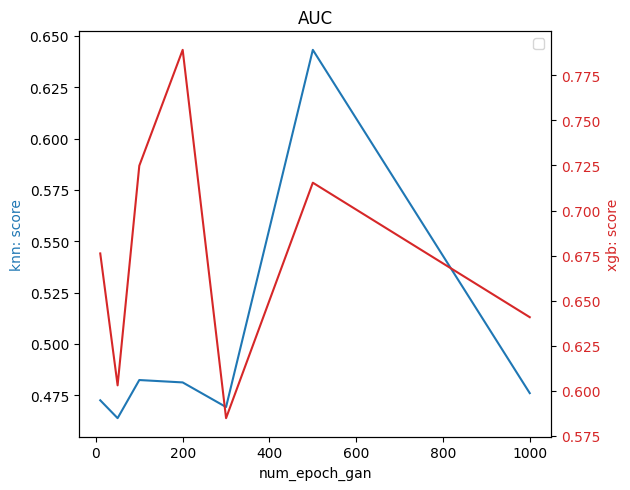

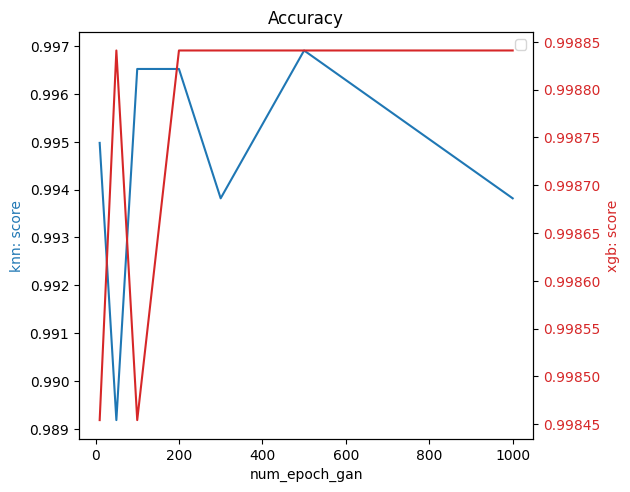

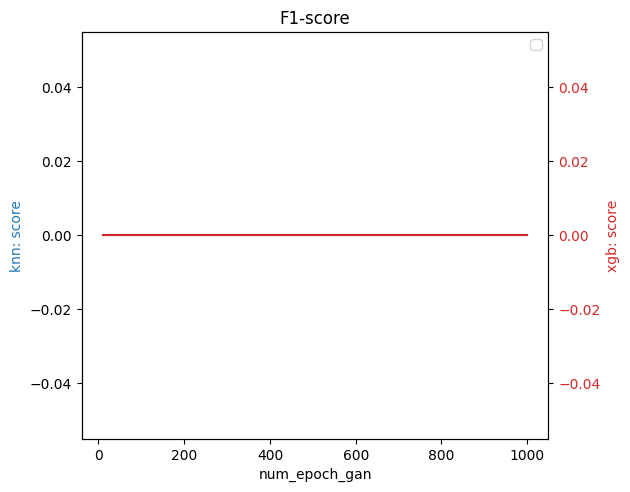

Total: 2.6130555868148804 min
gan_time: 2.5028488755226137 min


In [ ]:
#ANALISE INDIVIDUAL DO CGAN
import warnings
warnings.filterwarnings("ignore")

#!pip install numpy==1.24
#!pip install ctgan

import numpy as np
import pandas as pd
import time

from ctgan                  import CTGAN

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, mean_squared_error, r2_score, mean_absolute_error, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

#Tempos
StartTime   = time.time()
gan_time    = 0

#Entrada
ds = pd.read_csv('ELSA_CORE.csv')

ds_w = []
for ii in [3,4,5,6,7,8]:
  lst   = ([col for col in ds.columns if '_w'+str(ii) in col or 'sex' in col]) # or 'idauniq' in col -->id excluido
  df_w  = ds.loc[:,lst]
  df_w.columns = df_w.columns.str.replace('_w'+str(ii), "")
  df_w = df_w.replace("?", pd.NA).dropna()
  #df_w['class_dementia'] = df_w['class_dementia'].replace("?", pd.NA).dropna()
  for col in df_w.columns:
    if 'class' in col:
      df_w[col] = df_w[col].astype(int)
  ds_w.append(df_w)

wave    = 3
df_     = ds_w[wave-3]
df      = df_.copy()
df['class_dementia'] = df['class_dementia'].replace("0", pd.NA)
df=df.dropna()

#Tipos de colunas
discrete_cols = df.select_dtypes(include = [int]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df.select_dtypes(include=[float]).columns.tolist()
output_cols = df.columns.tolist()

# Dividir os dados em conjunto de treinamento e teste
data_real_train, data_real_test       = train_test_split(df_ , test_size=0.33, random_state=42)
data_real_train_min                   = data_real_train.loc[data_real_train['class_dementia'] == 1]

X_test = data_real_test.drop('class_dementia',axis=1)
y_test = data_real_test['class_dementia']

X_gan_lst = []
y_gan_lst = []

scores_cols = ['wave', 'num_epoch_gan','classifier', 'auc', 'precision', 'fscore']
xgb_scores  = pd.DataFrame(data=[], columns = scores_cols)
knn_scores  = pd.DataFrame(data=[], columns = scores_cols)
scores      = pd.DataFrame(data=[], columns = scores_cols)

gan_xgb_scores_lst = []
gan_knn_scores_lst = []

erros_cols = ['wave', 'num_epochs','mae','rmse','r2']
erros      = pd.DataFrame(data=[], columns = erros_cols)

pre_time = time.time() - StartTime
num_epochs = [10, 50, 100, 200, 300, 500, 1000]
for epoch in num_epochs:
  aux_time                        = time.time()
  ctgan                           = CTGAN(epochs=epoch)
  ctgan.fit(data_real_train_min, discrete_cols+categorical_cols)
  #print(data_real_train.shape[0])
  #print(data_real_train_min.shape[0])
  ctgan_data                      = ctgan.sample(data_real_train.shape[0]-data_real_train_min.shape[0])
  #print(ctgan_data.head())
  data_train                      = pd.concat([data_real_train, ctgan_data], ignore_index=True)
  X_gan                           = pd.concat([data_real_train, ctgan_data], ignore_index=True).drop('class_dementia', axis=1)
  y_gan                           = pd.concat([data_real_train, ctgan_data], ignore_index=True)['class_dementia']
  X_gan_lst.append(X_gan)
  y_gan_lst.append(y_gan)
  gan_time                        = gan_time + time.time() - aux_time

  #erros.append([wave, epoch, mean_absolute_error(data_real_train, data_train) ,np.sqrt(mean_squared_error(data_real_train, data_train)),r2_score(data_real_train, data_train)])

  X = X_gan.copy()
  y = y_gan.copy()


  # Treinar o modelo KNN
  knn_model         = KNeighborsClassifier()
  knn_model.fit(X, y)
  knn_predictions   = knn_model.predict(X_test)
  knn_probabilities = knn_model.predict_proba(X_test)
  knn_auc           = roc_auc_score(y_test, knn_probabilities[:, 1])
  knn_accuracy      = accuracy_score(y_test, knn_predictions)
  knn_fscore        = f1_score(y_test, knn_predictions)
  cm = confusion_matrix(y_test, knn_predictions)
  tn, fp, fn, tp = cm.ravel()
  knn_prec = tp / (tp + fp)

  knn_scores  = [wave, epoch, 'knn', knn_auc, knn_prec, knn_fscore]
  scores.loc[len(scores)] = knn_scores
  gan_knn_scores_lst.append(knn_scores)

  # Treinar o modelo XGBoost
  xgb_model         = XGBClassifier()
  xgb_model.fit(X, y)
  xgb_predictions   = xgb_model.predict(X_test)
  xgb_probabilities = xgb_model.predict_proba(X_test)
  xgb_auc           = roc_auc_score(y_test, xgb_probabilities[:, 1])
  xgb_accuracy      = accuracy_score(y_test, xgb_predictions)
  xgb_fscore        = f1_score(y_test, xgb_predictions)
  cm = confusion_matrix(y_test, xgb_predictions)
  tn, fp, fn, tp = cm.ravel()
  xgb_prec = tp / (tp + fp)

  xgb_scores  = [wave, epoch, 'xgb', xgb_auc, xgb_prec, xgb_fscore]
  scores.loc[len(scores)] = xgb_scores
  gan_xgb_scores_lst.append(xgb_scores)

  print(confusion_matrix(y_test, xgb_predictions))

df = scores[scores['wave']==wave]
#df = df[df['classifier']=='knn']
#df = df[df['sampler']=='gan']

print(df)
fig, ax1 = plt.subplots()
ax1.plot(df[df['classifier']=='knn']['num_epoch_gan'], df[df['classifier']=='knn']['auc'], color='tab:blue')
ax1.set_xlabel('num_epoch_gan')
ax1.set_ylabel('knn: score', color='tab:blue')
ax2 = ax1.twinx()
ax2.set_ylabel('xgb: score', color='tab:red')
ax2.plot(df[df['classifier']=='xgb']['num_epoch_gan'], df[df['classifier']=='xgb']['auc'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
fig.tight_layout()
plt.title('AUC')
plt.legend()
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(df[df['classifier']=='knn']['num_epoch_gan'], df[df['classifier']=='knn']['precision'], color='tab:blue')
ax1.set_xlabel('num_epoch_gan')
ax1.set_ylabel('knn: score', color='tab:blue')
ax2 = ax1.twinx()
ax2.set_ylabel('xgb: score', color='tab:red')
ax2.plot(df[df['classifier']=='xgb']['num_epoch_gan'], df[df['classifier']=='xgb']['precision'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
fig.tight_layout()
plt.title('Precision')
plt.legend()
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(df[df['classifier']=='knn']['num_epoch_gan'], df[df['classifier']=='knn']['fscore'], color='tab:blue')
ax1.set_xlabel('num_epoch_gan')
ax1.set_ylabel('knn: score', color='tab:blue')
ax2 = ax1.twinx()
ax2.set_ylabel('xgb: score', color='tab:red')
ax2.plot(df[df['classifier']=='xgb']['num_epoch_gan'], df[df['classifier']=='xgb']['fscore'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
fig.tight_layout()
plt.title('F1-score')
plt.legend()
plt.show()

TotalTime   = time.time() - StartTime
print("Total:" , TotalTime/60, "min")
print("gan_time:" , gan_time/60, "min")


In [17]:
#Fazer Loop de range IR usando diversos e utilizar diferentes métodos data augmentation
#DB1 : CTGAN
#DB2 : SMOTE
#DB3 : random over
#DB4 : nada
import warnings
warnings.filterwarnings("ignore")

#!pip install numpy==1.24
#!pip install ctgan

import numpy as np
import pandas as pd
import time

from ctgan                  import CTGAN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

#Tempos
StartTime   = time.time()
gan_time    = 0
smt_time    = 0
ros_time    = 0

ImbRatio      = [0.2,0.4,0.6,0.8,1] #0 sao apenas os dados reais e 1 sao 50%reais 50%

X_gan_lst = []
y_gan_lst = []
X_smt_lst = []
y_smt_lst = []
X_ros_lst = []
y_ros_lst = []

scores_cols = ['wave', 'ir', 'sampler','classifier', 'auc', 'precision', 'fscore']
xgb_scores  = pd.DataFrame(data=[], columns = scores_cols)
knn_scores  = pd.DataFrame(data=[], columns = scores_cols)
scores      = pd.DataFrame(data=[], columns = scores_cols)

gan_xgb_scores_lst = []
gan_knn_scores_lst = []
smt_xgb_scores_lst = []
smt_knn_scores_lst = []
ros_xgb_scores_lst = []
ros_knn_scores_lst = []


#Entrada
ds = pd.read_csv('ELSA_CORE.csv')

ds_w = []
for ii in [3,4,5,6,7,8]:
  lst   = ([col for col in ds.columns if '_w'+str(ii) in col or 'sex' in col]) # or 'idauniq' in col -->id excluido
  df_w  = ds.loc[:,lst]
  df_w.columns = df_w.columns.str.replace('_w'+str(ii), "")
  df_w = df_w.replace("?", pd.NA).dropna()
  #df_w['class_dementia'] = df_w['class_dementia'].replace("?", pd.NA).dropna()
  for col in df_w.columns:
    if 'class' in col:
      df_w[col] = df_w[col].astype(int)
  ds_w.append(df_w)

  wave    = ii
  df_     = ds_w[wave-3]
  df      = df_.copy()
  df['class_dementia'] = df['class_dementia'].replace("0", pd.NA)
  df=df.dropna()

  #Tipos de colunas
  discrete_cols = df.select_dtypes(include = [int]).columns.tolist()
  categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
  numeric_cols = df.select_dtypes(include=[float]).columns.tolist()
  output_cols = df.columns.tolist()

  # Dividir os dados em conjunto de treinamento e teste
  #data_real_train, data_real_test       = train_test_split(df_.drop('class_dementia', axis=1), df_['class_dementia'], test_size=0.33, random_state=42)
  data_real_train, data_real_test       = train_test_split(df_ , test_size=0.33, random_state=42)
  data_real_train_min                   = data_real_train.loc[data_real_train['class_dementia'] == 1]
  X_test = data_real_test.drop('class_dementia',axis=1)
  y_test = data_real_test['class_dementia']

  IR            = (data_real_train.shape[0]-data_real_train_min.shape[0])/data_real_train_min.shape[0]

  pre_time = time.time() - StartTime
  for ii in ImbRatio:
      aux_time                        = time.time()
      ctgan                           = CTGAN(epochs=100)
      ctgan.fit(data_real_train_min, discrete_cols+categorical_cols)
      ctgan_data                      = ctgan.sample(int(data_real_train.shape[0]*ii-data_real_train_min.shape[0]))
      X_gan                           = pd.concat([data_real_train, ctgan_data], ignore_index=True).drop('class_dementia', axis=1)
      y_gan                           = pd.concat([data_real_train, ctgan_data], ignore_index=True)['class_dementia']
      X_gan_lst.append(X_gan)
      y_gan_lst.append(y_gan)
      gan_time                        = gan_time + time.time() - aux_time

      aux_time                        = time.time()
      smote                           = SMOTE(sampling_strategy=ii)
      X_smt, y_smt                    = smote.fit_resample(X = data_real_train.drop('class_dementia', axis=1), y = data_real_train['class_dementia'])
      X_smt_lst.append(X_smt)
      y_smt_lst.append(y_smt)
      smt_time                        = smt_time + time.time() - aux_time

      aux_time                        = time.time()
      ros                             = RandomOverSampler(random_state=42, sampling_strategy=ii)
      X_ros, y_ros                    = ros.fit_resample(X = data_real_train.drop('class_dementia', axis=1), y = data_real_train['class_dementia'])
      X_ros_lst.append(X_ros)
      y_ros_lst.append(y_ros)
      ros_time                        = ros_time + time.time() - aux_time

      for jj in ["gan","smt","ros"]:
        if jj == "gan":
          X = X_gan.copy()
          y = y_gan.copy().astype(int)
        if jj == "smt":
          X = X_smt.copy()
          y = y_smt.copy().astype(int)
        if jj == "ros":
          X = X_ros.copy()
          y = y_ros.copy().astype(int)

        # Treinar o modelo XGBoost
        xgb_model         = XGBClassifier()
        xgb_model.fit(X, y)
        xgb_predictions   = xgb_model.predict(X_test)
        xgb_probabilities = xgb_model.predict_proba(X_test)
        xgb_auc           = roc_auc_score(y_test, xgb_probabilities[:, 1])
        xgb_accuracy      = accuracy_score(y_test, xgb_predictions)
        xgb_fscore        = f1_score(y_test, xgb_predictions)
        cm = confusion_matrix(y_test, xgb_predictions)
        tn, fp, fn, tp = cm.ravel()
        xgb_prec = tp / (tp + fp)

        # Treinar o modelo KNN
        knn_model         = KNeighborsClassifier()
        knn_model.fit(X, y)
        knn_predictions   = knn_model.predict(X_test)
        knn_probabilities = knn_model.predict_proba(X_test)
        knn_auc           = roc_auc_score(y_test, knn_probabilities[:, 1])
        knn_accuracy      = accuracy_score(y_test, knn_predictions)
        knn_fscore        = f1_score(y_test, knn_predictions)
        cm = confusion_matrix(y_test, knn_predictions)
        tn, fp, fn, tp = cm.ravel()
        knn_prec = tp / (tp + fp)

        xgb_scores  = [wave, ii, jj, 'xgb', xgb_auc, xgb_prec, xgb_fscore]
        knn_scores  = [wave, ii, jj, 'knn', knn_auc, knn_prec, knn_fscore]
        scores.loc[len(scores)] = xgb_scores
        scores.loc[len(scores)] = knn_scores
        scores
        if jj == "gan":
          gan_xgb_scores_lst.append(xgb_scores)
          gan_knn_scores_lst.append(knn_scores)
        if jj == "smt":
          smt_xgb_scores_lst.append(xgb_scores)
          smt_knn_scores_lst.append(knn_scores)
        if jj == "ros":
          ros_xgb_scores_lst.append(xgb_scores)
          ros_knn_scores_lst.append(knn_scores)


In [1]:
#Exemplo
cm = confusion_matrix(y_test, xgb_predictions)
tn, fp, fn, tp = cm.ravel()
print(tn)
print(fp)
print(fn)
print(tp)
xgb_prec = tp / (tp + fp)

NameError: ignored

    wave   ir sampler classifier       auc  precision  fscore
1      3  0.2     gan        knn  0.495606        NaN     0.0
3      3  0.2     smt        knn  0.491506        0.0     0.0
5      3  0.2     ros        knn  0.498243        0.0     0.0
7      3  0.4     gan        knn  0.495021        NaN     0.0
9      3  0.4     smt        knn  0.491506        0.0     0.0
11     3  0.4     ros        knn  0.498243        0.0     0.0
13     3  0.6     gan        knn  0.493263        0.0     0.0
15     3  0.6     smt        knn  0.491506        0.0     0.0
17     3  0.6     ros        knn  0.498243        0.0     0.0
19     3  0.8     gan        knn  0.479496        0.0     0.0
21     3  0.8     smt        knn  0.491506        0.0     0.0
23     3  0.8     ros        knn  0.498243        0.0     0.0
25     3  1.0     gan        knn  0.479789        0.0     0.0
27     3  1.0     smt        knn  0.491506        0.0     0.0
29     3  1.0     ros        knn  0.498243        0.0     0.0


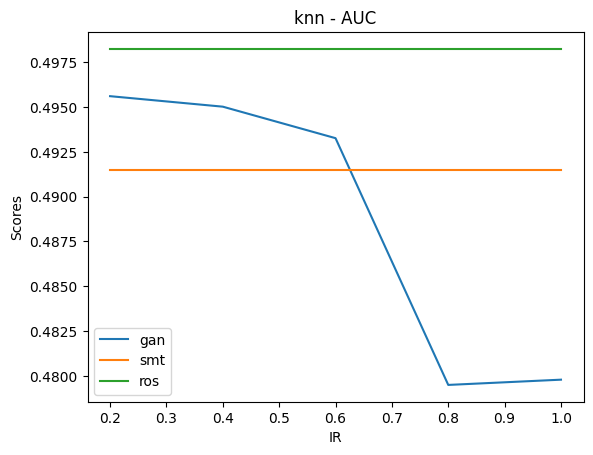

---------------------------


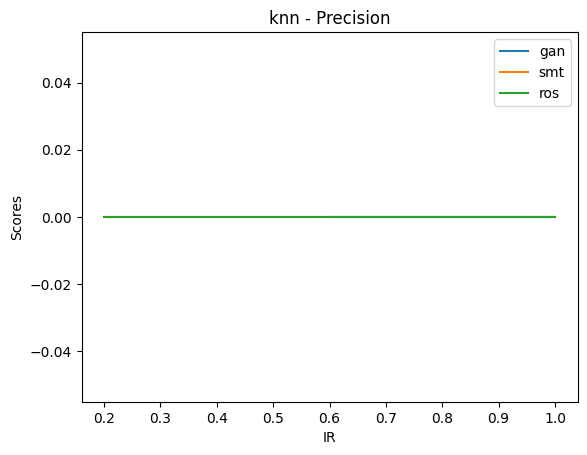

---------------------------


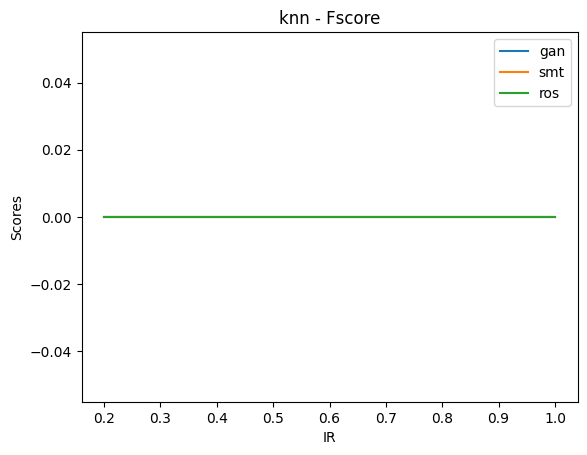

    wave   ir sampler classifier       auc  precision  fscore
0      3  0.2     gan        xgb  0.606327        0.0     0.0
2      3  0.2     smt        xgb  0.769479        0.0     0.0
4      3  0.2     ros        xgb  0.709139        NaN     0.0
6      3  0.4     gan        xgb  0.770943        NaN     0.0
8      3  0.4     smt        xgb  0.779438        0.0     0.0
10     3  0.4     ros        xgb  0.535149        0.0     0.0
12     3  0.6     gan        xgb  0.705624        NaN     0.0
14     3  0.6     smt        xgb  0.807264        0.0     0.0
16     3  0.6     ros        xgb  0.513181        0.0     0.0
18     3  0.8     gan        xgb  0.583187        NaN     0.0
20     3  0.8     smt        xgb  0.801992        0.0     0.0
22     3  0.8     ros        xgb  0.610428        0.0     0.0
24     3  1.0     gan        xgb  0.673989        0.0     0.0
26     3  1.0     smt        xgb  0.805800        0.0     0.0
28     3  1.0     ros        xgb  0.578207        0.0     0.0


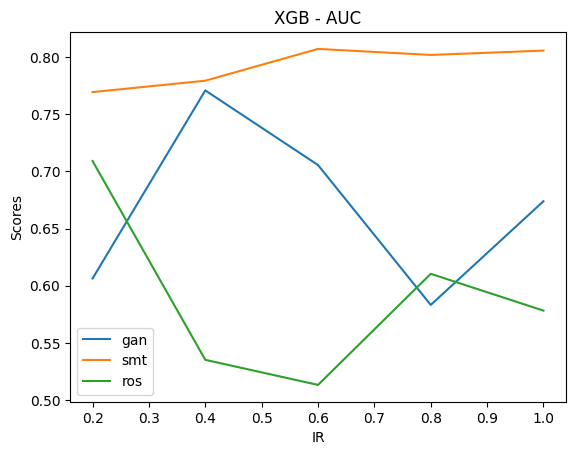

---------------------------


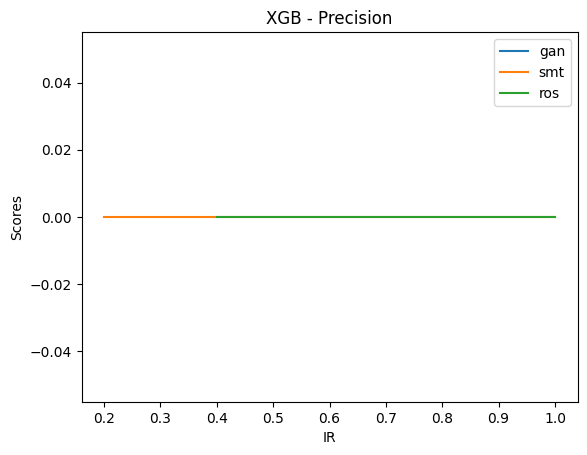

---------------------------


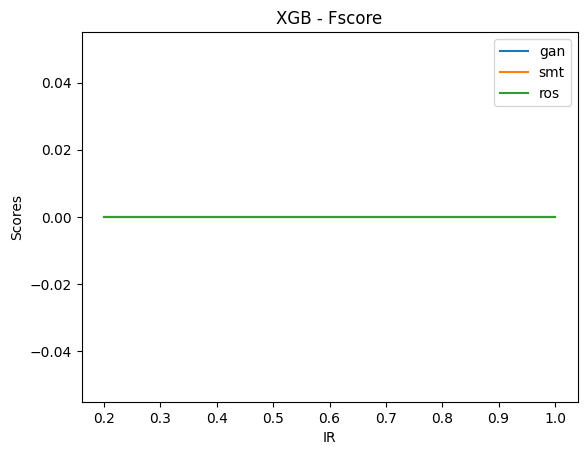

    wave   ir sampler classifier       auc  precision    fscore
31     4  0.2     gan        knn  0.613414   0.166667  0.142857
33     4  0.2     smt        knn  0.665395   0.027778  0.050000
35     4  0.2     ros        knn  0.557787   0.066667  0.086957
37     4  0.4     gan        knn  0.547913   0.111111  0.117647
39     4  0.4     smt        knn  0.664834   0.026316  0.047619
41     4  0.4     ros        knn  0.557787   0.066667  0.086957
43     4  0.6     gan        knn  0.544799   0.111111  0.117647
45     4  0.6     smt        knn  0.664722   0.025974  0.047059
47     4  0.6     ros        knn  0.557787   0.066667  0.086957
49     4  0.8     gan        knn  0.786440   0.041667  0.062500
51     4  0.8     smt        knn  0.664694   0.025641  0.046512
53     4  0.8     ros        knn  0.557787   0.066667  0.086957
55     4  1.0     gan        knn  0.778080   0.052632  0.074074
57     4  1.0     smt        knn  0.664666   0.025641  0.046512
59     4  1.0     ros        knn  0.5577

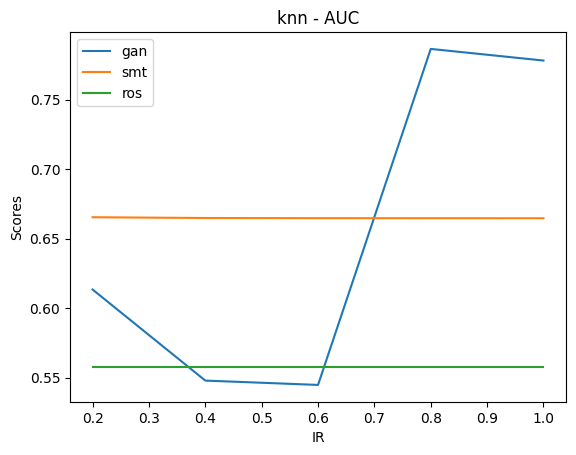

---------------------------


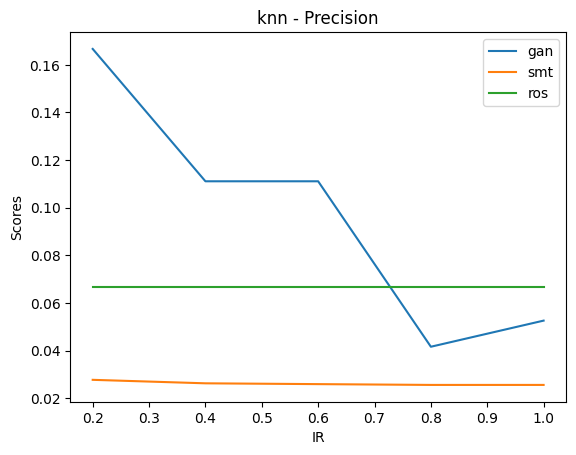

---------------------------


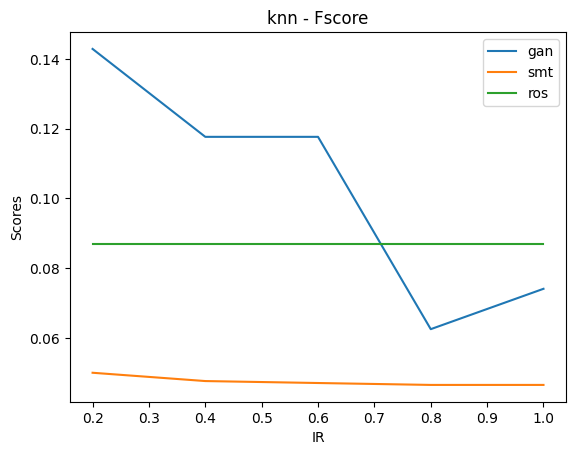

    wave   ir sampler classifier       auc  precision  fscore
30     4  0.2     gan        xgb  0.914722        NaN     0.0
32     4  0.2     smt        xgb  0.918705        0.0     0.0
34     4  0.2     ros        xgb  0.879657        0.0     0.0
36     4  0.4     gan        xgb  0.868380        0.0     0.0
38     4  0.4     smt        xgb  0.886726        0.0     0.0
40     4  0.4     ros        xgb  0.830509        0.0     0.0
42     4  0.6     gan        xgb  0.892729        NaN     0.0
44     4  0.6     smt        xgb  0.910682        0.0     0.0
46     4  0.6     ros        xgb  0.820298        0.0     0.0
48     4  0.8     gan        xgb  0.923698        NaN     0.0
50     4  0.8     smt        xgb  0.864396        0.0     0.0
52     4  0.8     ros        xgb  0.820803        0.0     0.0
54     4  1.0     gan        xgb  0.860806        0.0     0.0
56     4  1.0     smt        xgb  0.902491        0.0     0.0
58     4  1.0     ros        xgb  0.826582        0.0     0.0


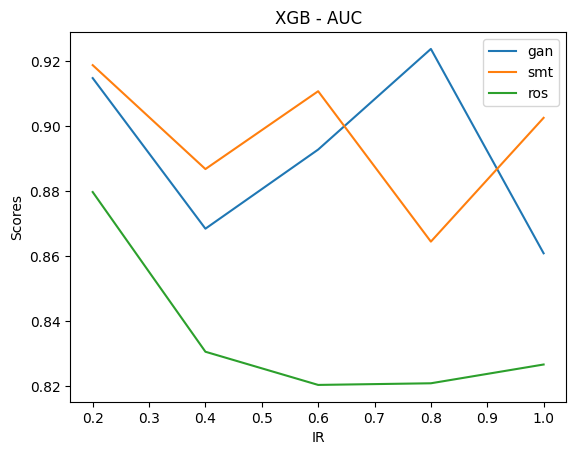

---------------------------


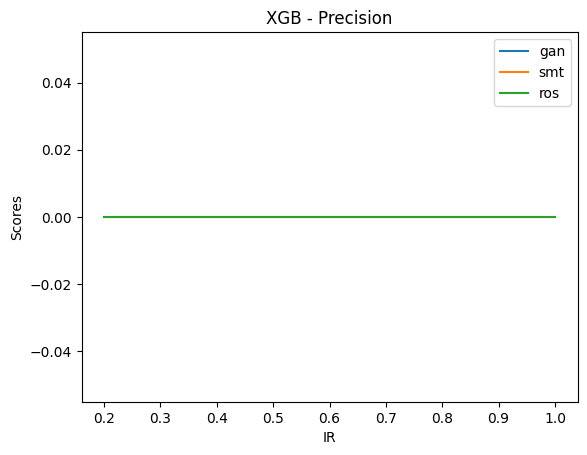

---------------------------


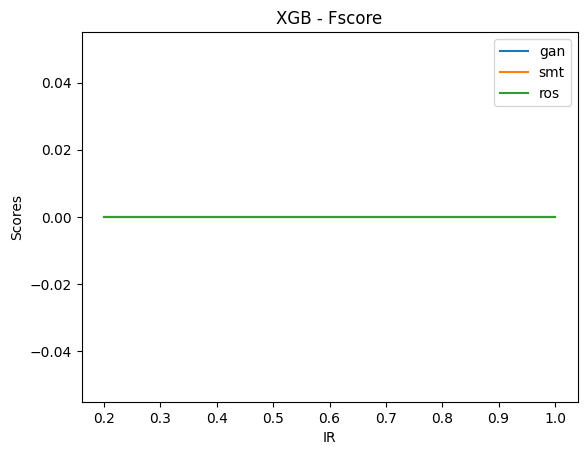

    wave   ir sampler classifier       auc  precision    fscore
61     5  0.2     gan        knn  0.778384   0.000000  0.000000
63     5  0.2     smt        knn  0.770390   0.028169  0.049383
65     5  0.2     ros        knn  0.645182   0.142857  0.193548
67     5  0.4     gan        knn  0.875296   0.000000  0.000000
69     5  0.4     smt        knn  0.770105   0.038462  0.068182
71     5  0.4     ros        knn  0.645182   0.142857  0.193548
73     5  0.6     gan        knn  0.809943   0.034483  0.051282
75     5  0.6     smt        knn  0.770696   0.037975  0.067416
77     5  0.6     ros        knn  0.645182   0.142857  0.193548
79     5  0.8     gan        knn  0.717630   0.035714  0.052632
81     5  0.8     smt        knn  0.770653   0.037500  0.066667
83     5  0.8     ros        knn  0.645182   0.142857  0.193548
85     5  1.0     gan        knn  0.924726   0.104167  0.172414
87     5  1.0     smt        knn  0.770894   0.037500  0.066667
89     5  1.0     ros        knn  0.6451

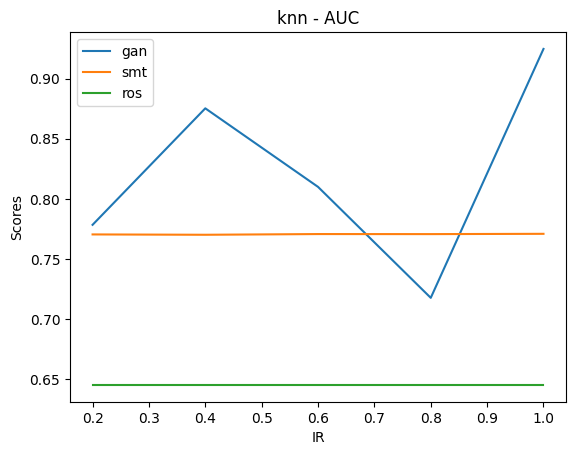

---------------------------


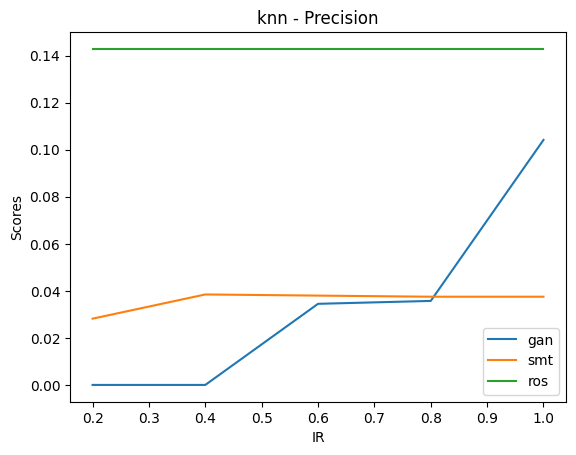

---------------------------


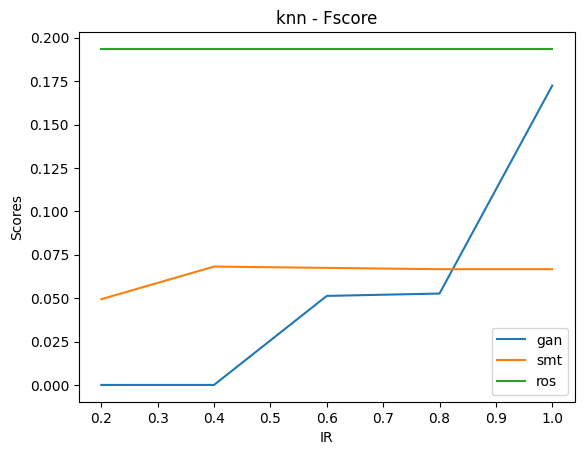

    wave   ir sampler classifier       auc  precision  fscore
60     5  0.2     gan        xgb  0.829085        0.0     0.0
62     5  0.2     smt        xgb  0.829435        0.0     0.0
64     5  0.2     ros        xgb  0.754753        0.0     0.0
66     5  0.4     gan        xgb  0.786159        0.0     0.0
68     5  0.4     smt        xgb  0.797985        0.0     0.0
70     5  0.4     ros        xgb  0.776916        0.0     0.0
72     5  0.6     gan        xgb  0.842707        0.0     0.0
74     5  0.6     smt        xgb  0.793780        0.0     0.0
76     5  0.6     ros        xgb  0.796802        0.0     0.0
78     5  0.8     gan        xgb  0.795357        0.0     0.0
80     5  0.8     smt        xgb  0.789049        0.0     0.0
82     5  0.8     ros        xgb  0.758257        0.0     0.0
84     5  1.0     gan        xgb  0.793430        0.0     0.0
86     5  1.0     smt        xgb  0.779457        0.0     0.0
88     5  1.0     ros        xgb  0.779501        0.0     0.0


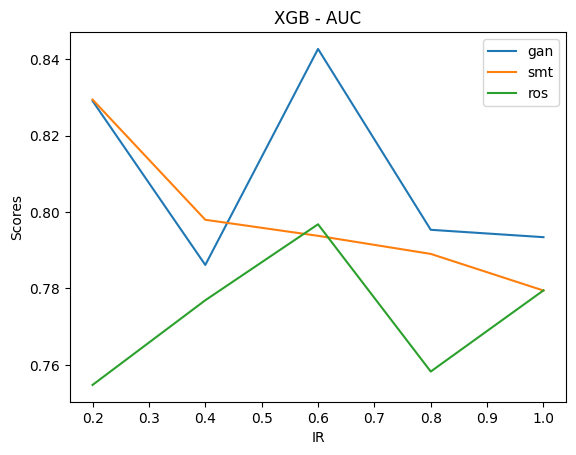

---------------------------


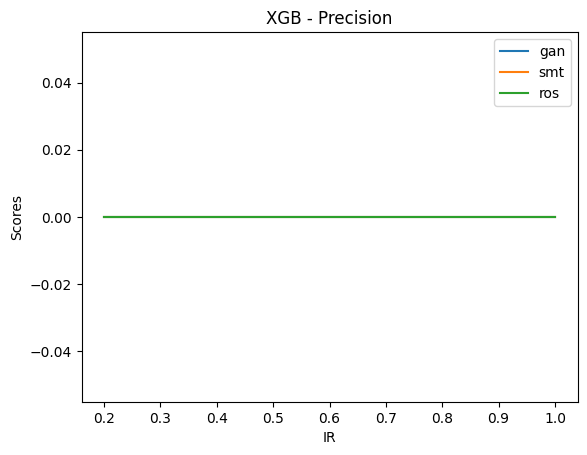

---------------------------


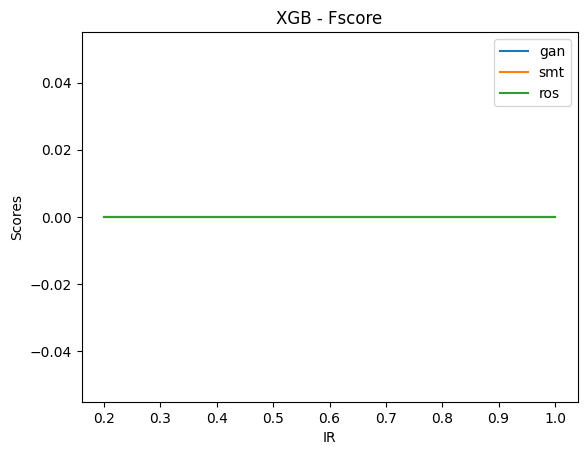

     wave   ir sampler classifier       auc  precision    fscore
91      6  0.2     gan        knn  0.687602   0.400000  0.266667
93      6  0.2     smt        knn  0.665352   0.029412  0.053571
95      6  0.2     ros        knn  0.591974   0.045455  0.062500
97      6  0.4     gan        knn  0.671881   0.083333  0.090909
99      6  0.4     smt        knn  0.663467   0.025000  0.046154
101     6  0.4     ros        knn  0.591974   0.045455  0.062500
103     6  0.6     gan        knn  0.633443   0.000000  0.000000
105     6  0.6     smt        knn  0.663408   0.024590  0.045455
107     6  0.6     ros        knn  0.591974   0.045455  0.062500
109     6  0.8     gan        knn  0.620754   0.071429  0.083333
111     6  0.8     smt        knn  0.663039   0.024390  0.045113
113     6  0.8     ros        knn  0.591974   0.045455  0.062500
115     6  1.0     gan        knn  0.651108   0.052632  0.068966
117     6  1.0     smt        knn  0.662962   0.024000  0.044444
119     6  1.0     ros   

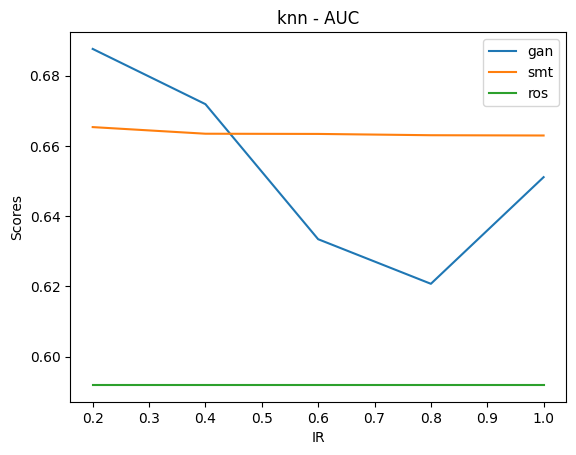

---------------------------


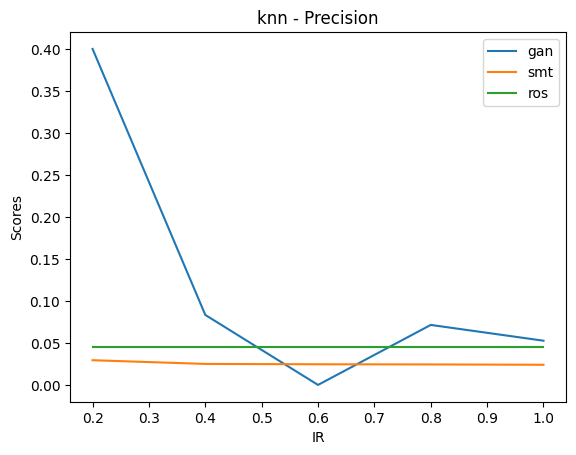

---------------------------


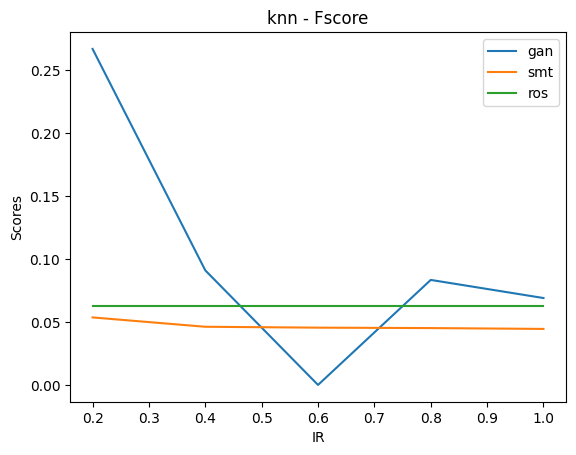

     wave   ir sampler classifier       auc  precision    fscore
90      6  0.2     gan        xgb  0.672522   0.000000  0.000000
92      6  0.2     smt        xgb  0.707346   0.200000  0.133333
94      6  0.2     ros        xgb  0.689953   0.200000  0.133333
96      6  0.4     gan        xgb  0.721104   0.000000  0.000000
98      6  0.4     smt        xgb  0.697085   0.250000  0.142857
100     6  0.4     ros        xgb  0.681733   0.200000  0.133333
102     6  0.6     gan        xgb  0.691644        NaN  0.000000
104     6  0.6     smt        xgb  0.735600   0.200000  0.133333
106     6  0.6     ros        xgb  0.671648   0.250000  0.142857
108     6  0.8     gan        xgb  0.725029   0.200000  0.133333
110     6  0.8     smt        xgb  0.760163   0.250000  0.142857
112     6  0.8     ros        xgb  0.698173   0.250000  0.142857
114     6  1.0     gan        xgb  0.668791   0.000000  0.000000
116     6  1.0     smt        xgb  0.774543   0.200000  0.133333
118     6  1.0     ros   

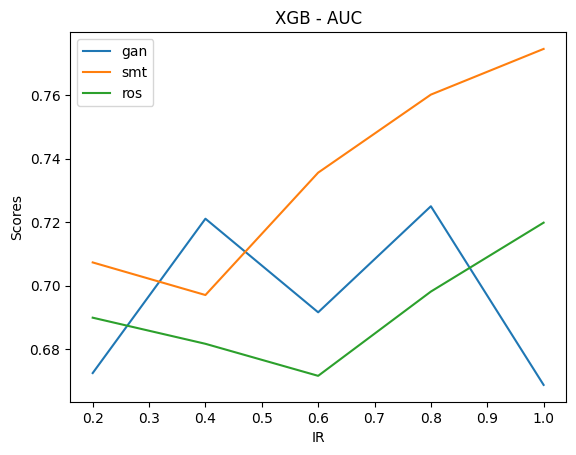

---------------------------


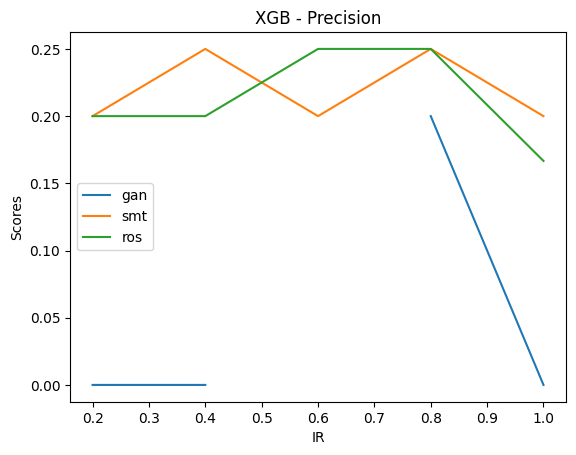

---------------------------


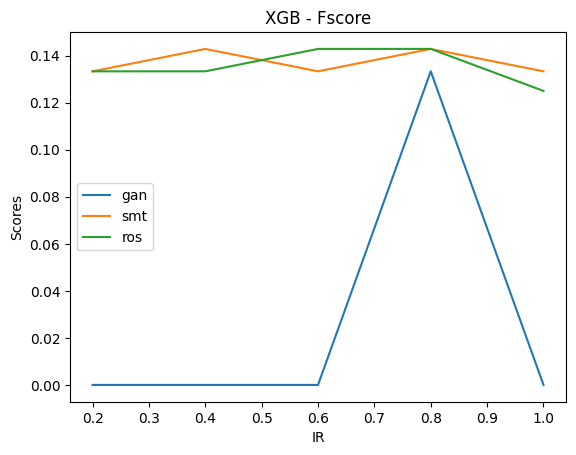

     wave   ir sampler classifier       auc  precision    fscore
121     7  0.2     gan        knn  0.719762   0.000000  0.000000
123     7  0.2     smt        knn  0.765468   0.046392  0.084112
125     7  0.2     ros        knn  0.683239   0.068966  0.102564
127     7  0.4     gan        knn  0.714656   0.142857  0.074074
129     7  0.4     smt        knn  0.792667   0.042918  0.079051
131     7  0.4     ros        knn  0.683239   0.068966  0.102564
133     7  0.6     gan        knn  0.704228   0.046512  0.063492
135     7  0.6     smt        knn  0.792129   0.045267  0.083650
137     7  0.6     ros        knn  0.683239   0.068966  0.102564
139     7  0.8     gan        knn  0.747980   0.000000  0.000000
141     7  0.8     smt        knn  0.792469   0.043651  0.080882
143     7  0.8     ros        knn  0.683239   0.068966  0.102564
145     7  1.0     gan        knn  0.831191   0.088235  0.136364
147     7  1.0     smt        knn  0.791874   0.042969  0.079710
149     7  1.0     ros   

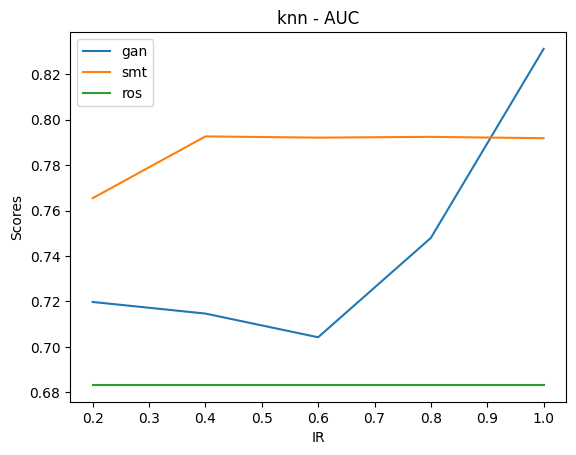

---------------------------


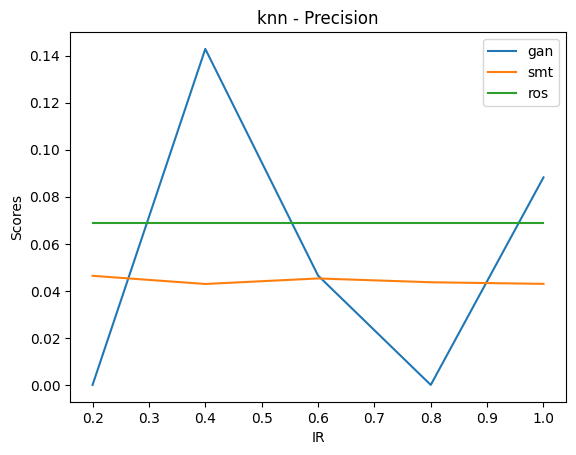

---------------------------


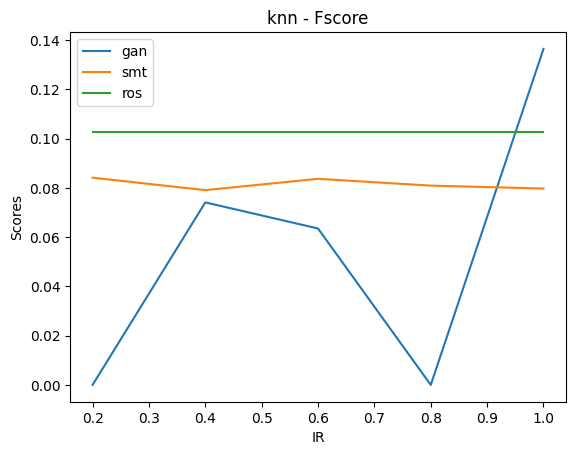

     wave   ir sampler classifier       auc  precision    fscore
120     7  0.2     gan        xgb  0.913477   0.333333  0.153846
122     7  0.2     smt        xgb  0.907626   0.428571  0.222222
124     7  0.2     ros        xgb  0.921291   0.428571  0.352941
126     7  0.4     gan        xgb  0.937958   0.666667  0.173913
128     7  0.4     smt        xgb  0.916082   0.500000  0.230769
130     7  0.4     ros        xgb  0.897829   0.500000  0.411765
132     7  0.6     gan        xgb  0.917856   0.666667  0.307692
134     7  0.6     smt        xgb  0.921687   0.285714  0.235294
136     7  0.6     ros        xgb  0.881200   0.333333  0.250000
138     7  0.8     gan        xgb  0.901359   0.500000  0.166667
140     7  0.8     smt        xgb  0.911778   0.272727  0.193548
142     7  0.8     ros        xgb  0.881370   0.437500  0.388889
144     7  1.0     gan        xgb  0.931597   0.428571  0.222222
146     7  1.0     smt        xgb  0.927690   0.300000  0.200000
148     7  1.0     ros   

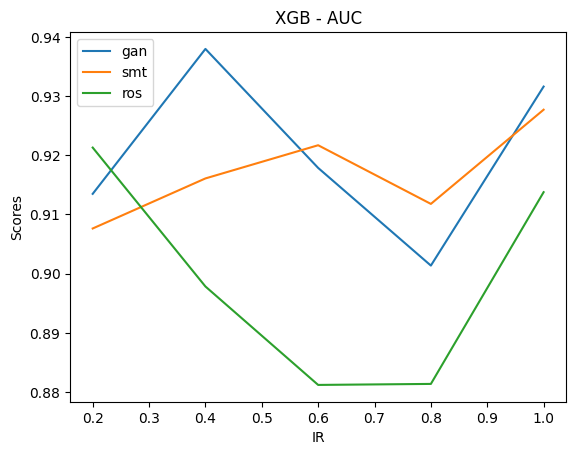

---------------------------


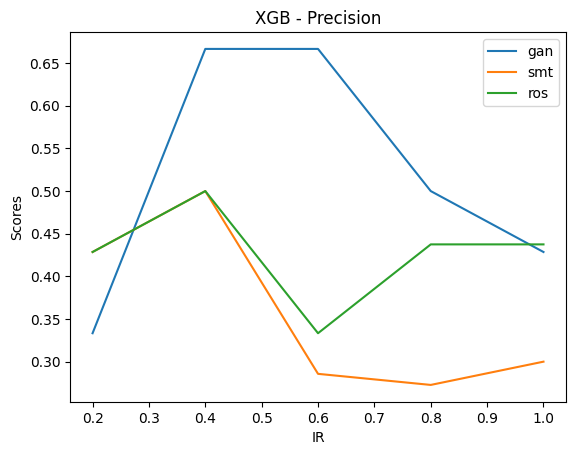

---------------------------


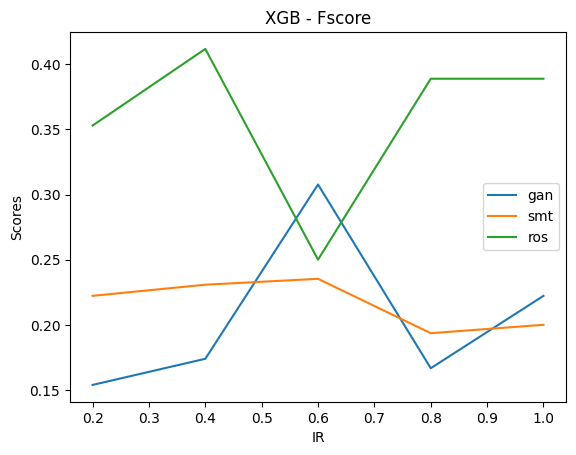

     wave   ir sampler classifier       auc  precision    fscore
151     8  0.2     gan        knn  0.724358   0.076190  0.096970
153     8  0.2     smt        knn  0.591777   0.055901  0.081448
155     8  0.2     ros        knn  0.567757   0.060606  0.075472
157     8  0.4     gan        knn  0.723910   0.092391  0.139344
159     8  0.4     smt        knn  0.591197   0.052632  0.081784
161     8  0.4     ros        knn  0.552355   0.060000  0.075000
163     8  0.6     gan        knn  0.721923   0.067416  0.115385
165     8  0.6     smt        knn  0.608192   0.059322  0.094595
167     8  0.6     ros        knn  0.567588   0.060606  0.075472
169     8  0.8     gan        knn  0.698207   0.069079  0.115385
171     8  0.8     smt        knn  0.613851   0.052632  0.085890
173     8  0.8     ros        knn  0.575679   0.061224  0.075949
175     8  1.0     gan        knn  0.746764   0.071429  0.122642
177     8  1.0     smt        knn  0.612942   0.051471  0.084337
179     8  1.0     ros   

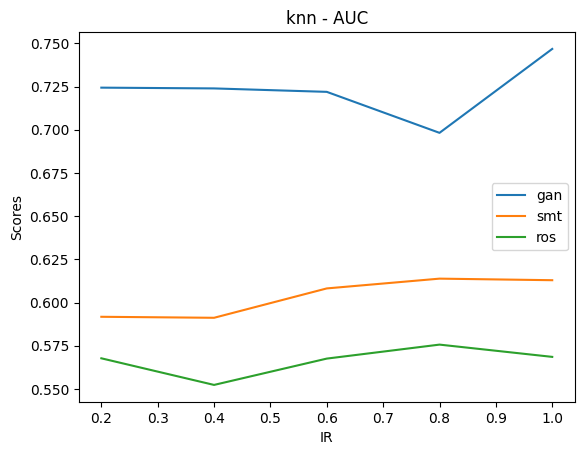

---------------------------


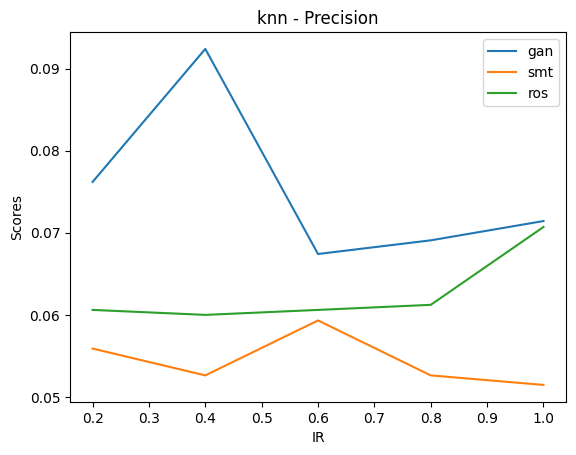

---------------------------


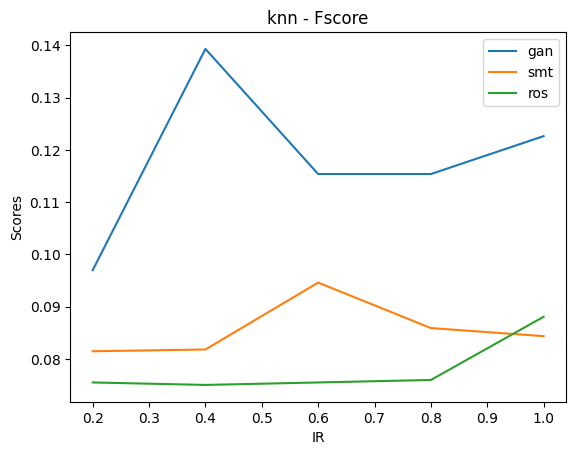

     wave   ir sampler classifier       auc  precision    fscore
150     8  0.2     gan        xgb  0.764499   0.000000  0.000000
152     8  0.2     smt        xgb  0.718257   0.109091  0.104348
154     8  0.2     ros        xgb  0.693518   0.052632  0.072539
156     8  0.4     gan        xgb  0.732345   0.111111  0.028986
158     8  0.4     smt        xgb  0.713937   0.092308  0.096000
160     8  0.4     ros        xgb  0.678807   0.052941  0.078261
162     8  0.6     gan        xgb  0.763483   0.166667  0.030303
164     8  0.6     smt        xgb  0.696131   0.081395  0.095890
166     8  0.6     ros        xgb  0.691482   0.056701  0.086614
168     8  0.8     gan        xgb  0.732673   0.111111  0.028986
170     8  0.8     smt        xgb  0.705733   0.081395  0.095890
172     8  0.8     ros        xgb  0.660216   0.050000  0.075000
174     8  1.0     gan        xgb  0.739250   0.066667  0.026667
176     8  1.0     smt        xgb  0.708508   0.081395  0.095890
178     8  1.0     ros   

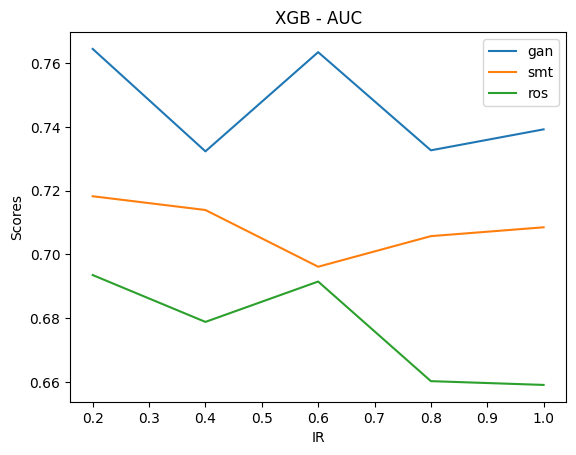

---------------------------


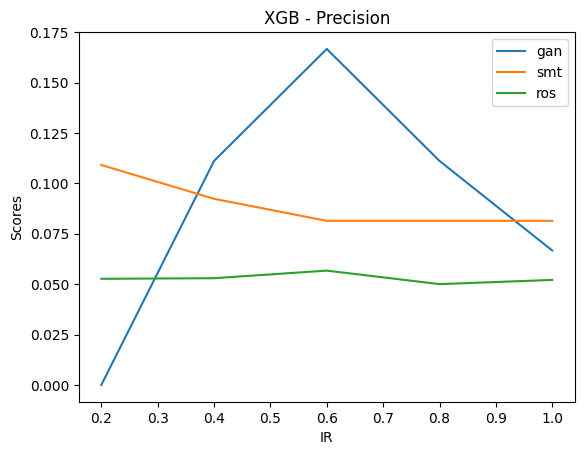

---------------------------


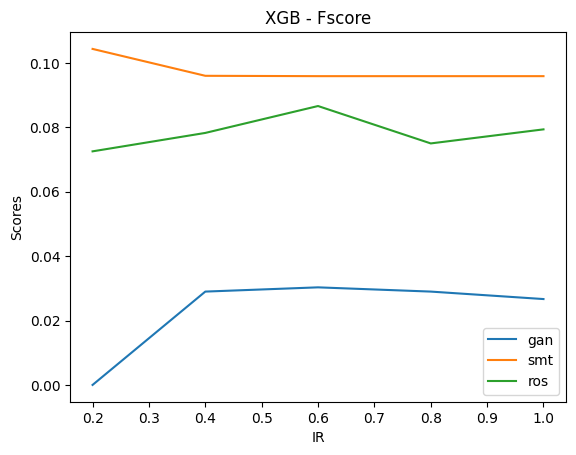

Total: 13.641614973545074 min
gan_time: 5.8457764705022175 min
smt_time: 0.5069539546966553 s
ros_time: 0.4378931522369385 s


In [18]:
#Impressão dos resultados
for wave in  [3,4,5,6,7,8]:
  df = scores[scores['wave']==wave]
  df = df[df['classifier']=='knn']
  #df = df[df['sampler']=='gan']

  print(df)
  plt.plot(df[df['sampler']=='gan']['ir'], df[df['sampler']=='gan']['auc'], label='gan')
  plt.plot(df[df['sampler']=='smt']['ir'], df[df['sampler']=='smt']['auc'], label='smt')
  plt.plot(df[df['sampler']=='ros']['ir'], df[df['sampler']=='ros']['auc'], label='ros')
  plt.xlabel('IR')
  plt.ylabel('Scores')
  plt.title('knn - AUC')
  plt.legend()
  plt.show()
  print("---------------------------")
  plt.plot(df[df['sampler']=='gan']['ir'], df[df['sampler']=='gan']['precision'], label='gan')
  plt.plot(df[df['sampler']=='smt']['ir'], df[df['sampler']=='smt']['precision'], label='smt')
  plt.plot(df[df['sampler']=='ros']['ir'], df[df['sampler']=='ros']['precision'], label='ros')
  plt.xlabel('IR')
  plt.ylabel('Scores')
  plt.title('knn - Precision')
  plt.legend()
  plt.show()
  print("---------------------------")
  plt.plot(df[df['sampler']=='gan']['ir'], df[df['sampler']=='gan']['fscore'], label='gan')
  plt.plot(df[df['sampler']=='smt']['ir'], df[df['sampler']=='smt']['fscore'], label='smt')
  plt.plot(df[df['sampler']=='ros']['ir'], df[df['sampler']=='ros']['fscore'], label='ros')
  plt.xlabel('IR')
  plt.ylabel('Scores')
  plt.title('knn - Fscore')
  plt.legend()
  plt.show()

  df = scores[scores['wave']==wave]
  df = df[df['classifier']=='xgb']
  #df = df[df['sampler']=='gan']

  print(df)
  plt.plot(df[df['sampler']=='gan']['ir'], df[df['sampler']=='gan']['auc'], label='gan')
  plt.plot(df[df['sampler']=='smt']['ir'], df[df['sampler']=='smt']['auc'], label='smt')
  plt.plot(df[df['sampler']=='ros']['ir'], df[df['sampler']=='ros']['auc'], label='ros')
  plt.xlabel('IR')
  plt.ylabel('Scores')
  plt.title('XGB - AUC')
  plt.legend()
  plt.show()
  print("---------------------------")
  plt.plot(df[df['sampler']=='gan']['ir'], df[df['sampler']=='gan']['precision'], label='gan')
  plt.plot(df[df['sampler']=='smt']['ir'], df[df['sampler']=='smt']['precision'], label='smt')
  plt.plot(df[df['sampler']=='ros']['ir'], df[df['sampler']=='ros']['precision'], label='ros')
  plt.xlabel('IR')
  plt.ylabel('Scores')
  plt.title('XGB - Precision')
  plt.legend()
  plt.show()
  print("---------------------------")
  plt.plot(df[df['sampler']=='gan']['ir'], df[df['sampler']=='gan']['fscore'], label='gan')
  plt.plot(df[df['sampler']=='smt']['ir'], df[df['sampler']=='smt']['fscore'], label='smt')
  plt.plot(df[df['sampler']=='ros']['ir'], df[df['sampler']=='ros']['fscore'], label='ros')
  plt.xlabel('IR')
  plt.ylabel('Scores')
  plt.title('XGB - Fscore')
  plt.legend()
  plt.show()


TotalTime   = time.time() - StartTime
print("Total:"    , TotalTime/60, "min")
print("gan_time:" , gan_time/60, "min")
print("smt_time:" , smt_time, "s")
print("ros_time:" , ros_time, "s")


In [6]:
data_real_train_min.shape[0]

3467


**CGAN PROPRIO**
--------------------------------------
Nesta tentativa será abordada a construção de um modelo proprio baseado no tensorflow... Ficará para um possível artigo.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Construir o gerador
def build_generator(latent_dim, num_classes, num_continuous):
    # Entradas
    input_discrete    = keras.Input(shape=(len(discrete_cols),))
    input_categorical = keras.Input(shape=(len(categorical_data),))
    input_continuous  = keras.Input(shape=(len(numeric_cols),))
    # Camadas para as colunas discretas
    dense_discrete    = layers.Dense(hidden_units, activation='relu')(input_discrete)
    # Camadas para as colunas categóricas
    dense_categorical = layers.Dense(hidden_units, activation='relu')(input_categorical)
    # Camadas para as colunas numéricas
    dense_continuous  = layers.Dense(hidden_units, activation='relu')(input_continuous)
    # Concatenar as saídas das camadas
    concatenated      = layers.concatenate([dense_discrete, dense_categorical, dense_continuous])
    # Camadas adicionais do gerador
    hidden            = layers.Dense(hidden_units*2, activation='relu')(concatenated)
    output            = layers.Dense(real_data.shape[1], activation='sigmoid')(hidden)

    # Modelo do gerador
    model             = keras.Model(inputs=[input_discrete, input_categorical, input_continuous], outputs=output)
    return model


def build_discriminator():
    model = keras.Sequential()
    model.add(layers.Dense(hidden_units*2, input_dim=real_data.shape[1], activation='relu'))
    model.add(layers.Dense(hidden_units, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Função de treinamento do GAN
@tf.function
def train_step(real_data):
    # Gerar ruído de entrada para o gerador
    batch_size = tf.shape(real_data)[0]
    noise = tf.random.normal([batch_size, latent_dim])

    # Gradientes persistentes para o discriminador
    with tf.GradientTape(persistent=True) as tape:
        # Gerar dados sintéticos com o gerador
        generated_data = generator(noise, training=True)

        # Avaliar o discriminador nos dados reais e falsos
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)

        # Calcular as perdas do discriminador
        d_loss_real = loss_fn(tf.ones_like(real_output), real_output)
        d_loss_fake = loss_fn(tf.zeros_like(fake_output), fake_output)
        total_d_loss = d_loss_real + d_loss_fake

        # Calcular a perda do gerador
        g_loss = loss_fn(tf.ones_like(fake_output), fake_output)

    # Calcular os gradientes e aplicar as atualizações
    gradients_discriminator = tape.gradient(total_d_loss, discriminator.trainable_weights)
    gradients_generator = tape.gradient(g_loss, generator.trainable_weights)
    discriminator_optimizer.apply_gradients(zip(gradients_discriminator, discriminator.trainable_weights))
    generator_optimizer.apply_gradients(zip(gradients_generator, generator.trainable_weights))

# Carregar os dados reais (se necessário)
real_data = pd.concat([df[discrete_cols],df[categorical_cols],df[numeric_cols]],axis=1)

# Separar os dados de entrada e saída
discrete_data = real_data[discrete_cols].values.astype('int32')
categorical_data = real_data[categorical_cols].values.astype('int32')
numeric_data = real_data[numeric_cols].values.astype('float32')
output_data = np.concatenate((discrete_data, categorical_data, numeric_data), axis=1) # real_data[output_cols].values


# Número de unidades nas camadas ocultas do gerador e do discriminador
hidden_units = 32

# Definir a dimensão do ruído de entrada
latent_dim = 100

# Construir o gerador
generator = build_generator(latent_dim, categorical_data.shape[1], numeric_data.shape[1])
generator.summary()

# Construir o discriminador
discriminator = build_discriminator()
discriminator.summary()

# Definir a função de perda e otimizadores para o gerador e o discriminador
loss_fn = keras.losses.BinaryCrossentropy()
generator_optimizer = keras.optimizers.Adam()
discriminator_optimizer = keras.optimizers.Adam()

# Loop de treinamento
num_epochs = 10000
batch_size = 32
num_batches = len(real_data) // batch_size

for epoch in range(num_epochs):
    # Embaralhar os dados reais
    #np.random.shuffle(real_data)

    for batch_idx in range(num_batches):
        # Obter um lote de dados reais
        batch_start = batch_idx * batch_size
        batch_end = (batch_idx + 1) * batch_size
        real_data_batch = real_data[batch_start:batch_end]

        # Executar um passo de treinamento
        train_step(real_data_batch)


# Gerar dados sintéticos com o gerador
num_samples = 100
noise = tf.random.normal([num_samples, latent_dim])
generated_data = generator([discrete_data[:num_samples], categorical_data[:num_samples], numeric_data[:num_samples]], training=False)

# Converter para um DataFrame do Pandas
generated_df = pd.DataFrame(generated_data.numpy(), columns=output_cols)

# Plotar os dados reais e sintéticos
plt.figure(figsize=(10, 6))
plt.scatter(real_data.iloc[:, 0], real_data.iloc[:, 1], color='blue', label='Real')
plt.scatter(generated_df.iloc[:, 0], generated_df.iloc[:, 1], color='red', label='Gerado')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Comparativo entre dados reais e sintéticos')
plt.legend()
plt.show()

print(generated_df.head(10))


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None, 12)]         0           []                               
                                                                                                  
 input_50 (InputLayer)          [(None, 8)]          0           []                               
                                                                                                  
 input_51 (InputLayer)          [(None, 16)]         0           []                               
                                                                                                  
 dense_130 (Dense)              (None, 32)           416         ['input_49[0][0]']               
                                                                                           

ValueError: ignored

SyntaxError: ignored

DP_CGAN -> https://github.com/sunchang0124/dp_cgans
problema no numpy tambem

--2023-06-30 09:24:04--  https://raw.githubusercontent.com/Diyago/GAN-for-tabular-data/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 183 [text/plain]
Saving to: ‘requirements.txt.13’

requirements.txt.13 100%[===================>]     183  --.-KB/s    in 0s      

2023-06-30 09:24:05 (7.93 MB/s) - ‘requirements.txt.13’ saved [183/183]

['indager', 'sex', 'cesd', 'cfmetm', 'cfmetper', 'heacta', 'heactb', 'heactc', 'headlno', 'headlX-of-6', 'heam', 'hecanaa', 'hecanb', 'hechm', 'hefrac', 'heiadlX-of-7', 'heill', 'heji', 'helng', 'hemobno', 'hemobX-of-10', 'hepaa', 'hepain', 'hepawX-of-7', 'hepsyX-of-9', 'heyrc', 'scako', 'smokerstat', 'class_heartattack', 'class_angina', 'class_stroke', 'class_diabetes', 'class_hbp', 'class_cataract',

ValueError: ignored